In [5]:
import numpy as np
import pymc as pm
import arviz as az
import plotly.express as px
import aesara.tensor as at
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from src.data.make_dataset import read_processed_data


In [6]:
ranking_df = read_processed_data()
ranking_df

,person,choc,person_idx,choc_idx,rank
0,jimmy,crunchie,5,2,0
0,jimmy,snickers,5,13,1
0,jimmy,fudge,5,7,2
0,jimmy,milky_way,5,12,3
0,jimmy,creme_egg,5,1,4
...,...,...,...,...,...
9,telf,fudge,8,7,12
9,telf,double_decker,8,5,13
9,telf,twix,8,15,14
9,telf,snickers,8,13,15


In [7]:
choc_rankings = np.swapaxes(np.array([ranking_df[ranking_df['person_idx']==i]['choc_idx'].
                            to_numpy() for i in range(10)]),
                            0, 1)

n_chocs = choc_rankings.shape[0]
n_people = choc_rankings.shape[1]

In [8]:
with pm.Model() as model:
    
    # overall distribution of mean preference values for chocolates
    choc_mus_fitted = pm.Normal("choc_mus_fitted",
                            0,
                            1,
                            shape=(n_chocs))

    # calculate standard deviation of fitted mu values to normalise scale of person ratings
    choc_mus_std = pm.Deterministic("choc_mus_std",
                                    at.std(choc_mus_fitted))

    #individual distributions of preferences across chocolates, hierarchically related to overall means      
    
    person_ratings = dict()

    for j in range(n_people):
        person_ratings[j] = pm.Normal("person_ratings_"+str(j),
                                        choc_mus_fitted[choc_rankings[:,j]]/choc_mus_std,
                                        1,
                                        transform=pm.distributions.transforms.ordered,
                                        initval=np.linspace(-2, 2, num=n_chocs),
                                        shape=n_chocs)
    
    idata = pm.sample(draws=200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [choc_mus_fitted, person_ratings_0, person_ratings_1, person_ratings_2, person_ratings_3, person_ratings_4, person_ratings_5, person_ratings_6, person_ratings_7, person_ratings_8, person_ratings_9]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 165 seconds.


array([[<AxesSubplot: title={'center': 'choc_mus_fitted'}>,
        <AxesSubplot: title={'center': 'choc_mus_fitted'}>]], dtype=object)

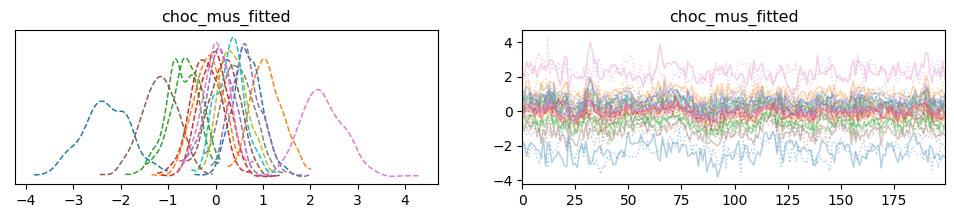

In [9]:
az.plot_trace(idata.posterior, var_names=['choc_mus_fitted'], combined=True)

In [10]:
df_dedup = ranking_df[['choc_idx','choc']].drop_duplicates().sort_values('choc_idx')

In [11]:
fig = px.violin(-idata.posterior.data_vars['choc_mus_fitted'][0,:,:])

fig.update_layout(
{
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
},
showlegend=False,
xaxis = dict(
        tickmode = 'array',
        tickvals = df_dedup['choc_idx'].tolist(),
        ticktext = df_dedup['choc'].tolist()
    ))



fig.update_xaxes(showline=True,
                    linewidth=1,
                    linecolor='black',
                    title='chocolate',
                    tickangle=270
                    )
fig.update_yaxes(showline=True,
                    linewidth=1,
                    linecolor='black',
                    title='underling preference')

fig.show()

In [12]:
sample_argsort = np.argsort(idata.posterior.data_vars['choc_mus_fitted'][0,:,:], axis=1)

In [13]:
n_rows = 6
n_cols = 3

fig = make_subplots(rows=n_rows,
                    cols=n_cols,
                    shared_xaxes='all',
                    shared_yaxes='all',
                    subplot_titles=df_dedup['choc'].tolist())

for i in range(n_chocs):

    row_idx = (i//n_cols) + 1
    col_idx = (i % n_cols) + 1
    fig.append_trace(
        go.Histogram(x=np.where(sample_argsort==i)[1],
                        histnorm='probability',
                        name=str(i)),
        row=row_idx,
        col=col_idx
    )

fig.update_layout(
{
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
},
showlegend=False,
height=1000,
width=800,
font=dict(
        size=10
    ))

fig.update_xaxes(showline=True,
                    showticklabels=True,
                    linewidth=1,
                    linecolor='black',
                    tick0=0,
                    dtick=1,
                    tickangle=270
                    )
fig.update_yaxes(showline=True,
                    showticklabels=True,
                    linewidth=1,
                    linecolor='black',
                    tick0=0,
                    dtick=0.25)

fig.show()